In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

from os import path

In [2]:
from utils import *
from hash_utils import digest
from game_model import game
from rp_model import computeRP
from variables import *
from computed import computedColumns
from initial_guess import make_initial_guess


In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_29": "1691041080",
}

rp_data_file = './data/rp-data.pickle'


if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_29 = download_sheet(rp_file_id, sheet_ids["data_10_29"])
    
    data = pd.concat([data_1_9, data_10_29], axis = 0)
    data = data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"])
    data = data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1})
    data = data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''})

    # avoid second food item
    data = data[ data["Level"] < 30 ]
    
    # avoid a bug in RP of freshly catched mon with skill up unlocked.
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) & (data["Level"] > 9) )]
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) & (data["Level"] > 9) )]
    
    data.to_pickle(rp_data_file)
    
else:
    
    data = pd.read_pickle(rp_data_file)
    

In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.0,5465.0,5465.0,5465.000000,5465.000000
mean,9.504483,558.335041,1.399634,558.326214,-0.008827,3999.432754,3863.991508,12.022507,28.004209,36.541812,108.899360,0.998525,0.989268,0.994979,1.001025,1.005672,0.206873,30.613036,53.119122,145.736139,1.0,0.0,0.0,0.989369,1.025429
std,6.251181,326.788079,0.898714,326.800586,0.795908,942.987550,1003.505055,3.315086,2.612509,6.863081,15.761472,0.291601,0.059411,0.045319,0.118243,0.118452,0.043644,32.873601,25.247767,54.726980,0.0,0.0,0.0,0.034974,0.066618
min,1.000000,245.000000,1.000000,245.050000,-9.450000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.980000,25.000000,90.000000,1.0,0.0,0.0,0.790000,1.000000
25%,5.000000,349.000000,1.000000,348.870000,-0.310000,3400.000000,3079.788000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,11.980000,35.000000,101.000000,1.0,0.0,0.0,1.000000,1.000000
50%,8.000000,436.000000,1.000000,436.080000,-0.050000,4000.000000,3853.200000,11.000000,28.000000,35.000000,103.000000,0.930000,1.000000,1.000000,1.000000,1.000000,0.200000,18.180000,43.000000,121.000000,1.0,0.0,0.0,1.000000,1.000000
75%,12.000000,663.000000,1.000000,662.910000,0.230000,4500.000000,4482.000000,14.000000,30.000000,40.000000,115.000000,1.160000,1.000000,1.000000,1.000000,1.000000,0.230000,43.060000,66.000000,202.000000,1.0,0.0,0.0,1.000000,1.000000
max,29.000000,3432.000000,6.000000,3431.840000,7.100000,6300.000000,6916.140000,23.000000,35.000000,67.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.380000,413.870000,195.000000,302.000000,1.0,0.0,0.0,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,8.0,531.0,Hardy,1,Questions help guides,530.68,-0.32,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.78,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,9.0,574.0,Naughty,1,Rate My Mon,574.38,0.38,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.78,538.38,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1,Questions help guides,538.05,0.05,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.78,530.63,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3,,957.93,-0.07,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.46,937.91,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2,pokemon sleep general,714.96,-0.04,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.16,750.12,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [6]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [7]:
# Compute per sample information about help time, nature, subskills etc
computed = computedColumns(data)

# Do we match sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    5465.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [8]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return computeRP(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)


count    5465.000000
mean        0.513540
std         3.934690
min         0.000397
25%         0.130387
50%         0.268325
75%         0.413135
max       166.312990
dtype: float64

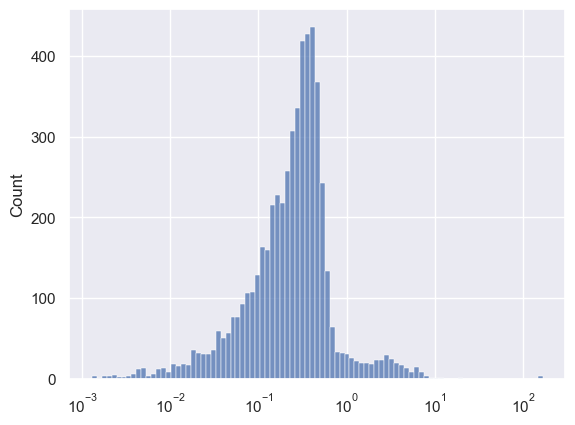

In [9]:
# what is the quality of the initial guess ?

r = np.abs(residual(x0))
pd.Series(r).describe()
_ = sns.histplot(x=r[r>1e-3], log_scale=True)

In [10]:
cache_fit = True

# least_squares gives a deterministic result that depend on x0, the data, and the otimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = f"./results/linear-fit-{digest(data, x0)}.npy"

if cache_fit and path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")
else:
    opt = scipy.optimize.least_squares(residual, x0, loss="soft_l1", xtol=None, verbose=2) 
    
    # save result and remobe some stuff we don't neeed to save.
    del opt.jac
    del opt.active_mask
    del opt.fun
    
    save(filename, opt)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4317e+03                                    9.98e+06    
       1              8         1.3756e+03      5.61e+01       8.22e-02       6.61e+05    
       2             13         1.3528e+03      2.28e+01       3.21e-04       5.32e+04    
       3             14         1.3475e+03      5.25e+00       6.42e-04       4.30e+05    
       4             15         1.3416e+03      5.93e+00       6.42e-04       2.70e+05    
       5             16         1.3383e+03      3.25e+00       6.42e-04       1.92e+05    
       6             17         1.3365e+03      1.80e+00       6.42e-04       1.54e+04    
       7             18         1.3348e+03      1.74e+00       1.28e-03       1.96e+03    
       8             19         1.3326e+03      2.21e+00       2.57e-03       1.30e+03    
       9             20         1.3288e+03      3.76e+00       5.14e-03       2.89e+03    

In [11]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.562e-01  2.545e-01 ...  2.196e-01  2.194e-01]
       cost: 814.695264281178
       grad: [-6.245e-07 -3.453e-05 ... -6.397e-05 -3.049e-05]
 optimality: 0.03631047531962395
       nfev: 58
       njev: 40

count    5465.000000
mean        0.399477
std         0.687682
min         0.000000
25%         0.129198
50%         0.267502
75%         0.413961
max         9.373141
dtype: float64

<Axes: ylabel='Count'>

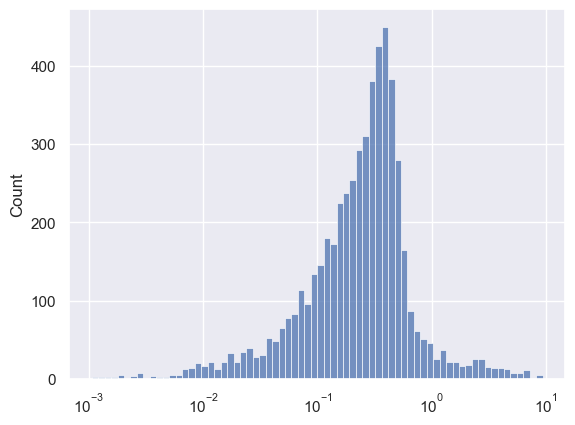

In [12]:
r_opt = np.abs(residual(opt.x))
pd.Series(r_opt).describe()
sns.histplot(x=r_opt[r_opt>1e-3], log_scale=True)

In [13]:
sol = unpack(opt.x, unpack_info)

table(sol)

Pokemons ing fractions,[0.25621458 0.25454277 0.26578648 ... 0.17953362 0.20050572 0.21655103]
Pokemons skill products,[16.72932185 16.70439551 18.42791886 ... 44.72570761 12.8003325 15.26688156]
Charge Strength S,[0.74767618 0.32196885]
Charge Strength M,[0.74480501 0.3228574 ]
Ingredient Magnet S,[0.74536224 0.32274332]
Cooking Power-Up S,[0.74530239 0.32268706]
Extra Helpful S,[0.74527447 0.32269435]
Charge Energy S,[0.74742295 0.32205932]
Energizing Cheer S,[0.73441813 0.33138656]
Energy for Everyone S,[0.74576628 0.32261389]
Dream Shard Magnet S,[0.74707557 0.32200814]


In [14]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.pokedex.data["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.621458,16.729322
Ivysaur,25.454277,16.704396
Venusaur,26.578648,18.427919
Charmander,20.039688,9.680895
Charmeleon,22.666308,14.052708
Charizard,22.419676,14.009639
Squirtle,26.997887,17.626546
Wartortle,27.056830,17.577407
Blastoise,27.455203,18.436862


In [15]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.mainskills.data.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.423548,1.420604,1.421342,1.421068,1.421036,1.423323,1.424892,1.421745,1.422516,1.421709
3,1.964271,1.961951,1.962747,1.962258,1.962228,1.964139,1.984730,1.963049,1.962925,1.964056
4,2.710383,2.709588,2.710379,2.709551,2.709529,2.710446,2.764527,2.710444,2.708632,2.713295
5,3.739900,3.742127,3.742791,3.741438,3.741434,3.740325,3.850704,3.742397,3.737630,3.748350
6,5.160471,5.168133,5.168461,5.166302,5.166334,5.161524,5.363639,5.167248,5.157541,5.178253


In [16]:
# What are the worst points ?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
336,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.626859,9.373141,87.855771
2150,Togekiss,TogekissGentle103Skill Trigger M,10.0,3,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.702293,9.297707,86.447360
358,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.306434,8.693566,75.578082
535,Charmeleon,CharmeleonQuiet252Inventory Up MSleep EXP Bonus,25.0,2,Ingredient Finding,Exp Gains,Inventory Up M,Sleep EXP Bonus,1063.0,1054.410957,8.589043,73.771659
1831,Raticate,RaticateBrave281Inventory Up MSleep EXP Bonus,28.0,1,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1097.0,1088.750306,8.249694,68.057446
272,Butterfree,ButterfreeImpish265Skill Level Up MSleep EXP B...,26.0,5,Energy Recovery,Ingredient Finding,Skill Level Up M,Sleep EXP Bonus,1404.0,1411.101808,-7.101808,50.435676
2058,Sudowoodo,SudowoodoHasty162Berry Finding S,16.0,2,EXP Gains,Energy Recovery,Berry Finding S,,743.0,750.017565,-7.017565,49.246216
1394,Leafeon,LeafeonRelaxed102Inventory Up M,10.0,2,Energy Recovery,EXP Gains,Inventory Up M,,944.0,937.179015,6.820985,46.525836
315,Butterfree,ButterfreeSassy102Helping bonus,10.0,2,Main Skill Chance,EXP Gains,Helping bonus,,816.0,809.202588,6.797412,46.204804
232,Butterfree,ButterfreeCareful103Berry Finding S,10.0,3,Main Skill Chance,Ingredient Finding,Berry Finding S,,910.0,903.356011,6.643989,44.142590
